<a href="https://colab.research.google.com/github/albertometelli/rl-phd-2022/blob/main/02_gym_environment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build a Gym Environment

This notebook is inspired to the Stable Baselines3 tutorial available at [https://github.com/araffin/rl-tutorial-jnrr19](https://github.com/araffin/rl-tutorial-jnrr19).


## Introduction

In this notebook, we will learn how to build a customized environment with **Open AI Gym**.

### Links

Open AI Gym Github: [https://github.com/openai/gym](https://github.com/openai/gym)

Open AI Gym Documentation: [https://www.gymlibrary.ml](https://www.gymlibrary.ml)

Stable Baselines 3 Github:[https://github.com/DLR-RM/stable-baselines3](https://github.com/DLR-RM/stable-baselines3)

Stable Baseline 3 Documentation: [https://stable-baselines3.readthedocs.io/en/master/](https://stable-baselines3.readthedocs.io/en/master/)

## Install Dependencies and Stable Baselines3 Using Pip

In [13]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines3[extra]

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Reason for being yanked: re-release with new wheels
  Using cached atari-py-0.2.6.tar.gz (790 kB)
  ERROR: Command errored out with exit status 1:
   command: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-6bu0gfxa/atari-py/setup.py'"'"'; __file__='"'"'/tmp/pip-install-6bu0gfxa/atari-py/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-1ubdoa4i
       cwd: /tmp/pip-install-6bu0gfxa/atari-py/
  Complete output (502 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.8
  creating build/lib.linux-x86_64-3.8/atari_py
  copying atari_py/ale_python_interfa

Failed to build atari-py
    Running setup.py install for atari-py ... error
    ERROR: Command errored out with exit status 1:
     command: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-6bu0gfxa/atari-py/setup.py'"'"'; __file__='"'"'/tmp/pip-install-6bu0gfxa/atari-py/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-u4uyi084/install-record.txt --single-version-externally-managed --user --prefix= --compile --install-headers /home/alberto/.local/include/python3.8/atari-py
         cwd: /tmp/pip-install-6bu0gfxa/atari-py/
    Complete output (504 lines):
    running install
    running build
    running build_py
    creating build
    creating build/lib.linux-x86_64-3.8
    creating build/lib.linux-x86_64-3.8/atari_py
    copying atari_py/ale_python_interface.py -> build/lib.linux-x86

ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-6bu0gfxa/atari-py/setup.py'"'"'; __file__='"'"'/tmp/pip-install-6bu0gfxa/atari-py/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-u4uyi084/install-record.txt --single-version-externally-managed --user --prefix= --compile --install-headers /home/alberto/.local/include/python3.8/atari-py Check the logs for full command output.


In [74]:
import stable_baselines3
stable_baselines3.__version__

'1.4.0'

## Evaluation

A helper function to evaluate policies.

In [13]:
def evaluate(env, policy, gamma=1., num_episodes=100):
    """
    Evaluate a RL agent
    :param env: (Env object) the Gym environment
    :param policy: (BasePolicy object) the policy in stable_baselines3
    :param gamma: (float) the discount factor
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    discounter = 1.
    all_episode_rewards = []
    for i in range(num_episodes): # iterate over the episodes
        episode_rewards = []
        done = False
        obs = env.reset()
        while not done: # iterate over the steps until termination
            action, _ = policy.predict(obs)
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward * discounter) # compute discounted reward
            discounter *= gamma

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    std_episode_reward = np.std(all_episode_rewards) / np.sqrt(num_episodes - 1)
    print("Mean reward:", mean_episode_reward, 
          "Std reward:", std_episode_reward,
          "Num episodes:", num_episodes)

    return mean_episode_reward, std_episode_reward

## Plotting

A helper function to plot the learning curves.

In [14]:
import matplotlib.pyplot as plt


def plot_results(results):
    plt.figure()
    
    for k in results.keys():
        data = np.load(results[k] + '/evaluations.npz')
        ts = data['timesteps']
        res = data['results']
        _mean, _std = res.mean(axis=1), res.std(axis=1)

        plt.plot(ts, _mean, label=k)
        plt.fill_between(ts, _mean-_std, _mean+_std, alpha=.2)
        
    plt.xlabel('Timesteps')
    plt.ylabel('Average return')
    plt.legend(loc='lower right')
    
    plt.show()

## The Minigolf Environment

The `Minigolf` environment models a simple problem in which the agent has to hit a ball on a green using a putter in order to reach the hole with the minimum amount of moves. 

* The green is characterized by a **friction** $f$ that is selected uniformly random at the beginning of each episode in the interval `[0.065, 0.196]` and does not change during the episode. 
* The **position** of the ball is represented by a unidimensional variable $x_t$ that is initialized uniformly random in the interval `[1,20]`. The observation is made of the pair $s_t = (x_t,f)$. 
* The **action** $a_t$ is the force applied to the putter and has to be bounded in the interval `[1e-5,5]`. Before being applied the action is subject to a Gaussian noise, so that the actual action $u_t$ applied is given by:

$$
u_t = a_t + \epsilon \qquad \text{where} \qquad \epsilon \sim \mathcal{N}(0,\sigma^2),
$$
where $\sigma =0.1$. The movement of the ball is governed by the kinematic law:

$$
x_{t+1} = x_{t} - v_t \tau_t + \frac{1}{2} d \tau_t^2
$$

where:
* $v_t$ is the velocity computed as $v_t = u_t l$,
* $d$ is the deceleration computed as $d = \frac{5}{7} fg$,
* $\tau_t$ is the time interval computed as $\tau_t = \frac{v_t}{d}$. 

The remaining constants are the putter length $l = 1$ and the gravitational acceleration $g=9.81$. The **episode** terminates when the next state is such that the ball enters or surpasses (without entering) the hole. The **reward** is `-1` at every step and `-100` if the ball surpasses the hole. To check whether the ball will not reach, enter, or surpass the hole, refer to the following condition:

\begin{align*}
&v_t < v_{\min} \implies \text{ball does not reach the hole} \\
&v_t > v_{\max} \implies \text{ball surpasses the hole} \\
&\text{otherwise} \implies \text{ball enters the hole}
\end{align*}

where

\begin{align*}
& v_\min = \sqrt{\frac{10}{7} fgx_t}
& v_\max = \sqrt{ \frac{g(2 h - \rho)^2}{2r} + v_\min^2},
\end{align*}
where $h = 0.1$ is the hole size and $\rho = 0.02135$ is the ball radius.


**References**

Penner, A. R. "The physics of putting." Canadian Journal of Physics 80.2 (2002): 83-96.

In [21]:
import gym
import numpy as np
from gym.spaces import Box

class Minigolf(gym.Env):
    """
    The Minigolf problem.
    
    """

    def __init__(self):
        super(Minigolf, self).__init__()
        
        # Constants
        self.min_pos, self.max_pos = 1.0, 20.0
        self.min_action, self.max_action = 1e-5, 5.0
        self.min_friction, self.max_friction = 0.065, 0.196
        self.putter_length = 1.0
        self.hole_size = 0.10
        self.sigma_noise = 0.1
        self.ball_radius = 0.02135
        

        # Instance the spaces
        low = np.array([self.min_pos, self.min_friction])
        high = np.array([self.max_pos, self.max_friction])
        
        self.action_space = Box(low=self.min_action,
                                high=self.max_action,
                                shape=(1,), 
                                dtype=np.float32)
        
        self.observation_space = Box(low=low, 
                                     high=high, 
                                     shape=(2,),
                                     dtype=np.float32)
                                                    
            
    def step(self, action):
        
        #Retrieve the state components
        x, friction = self.state

        # Clip the action within the allowed range
        action = np.clip(action, self.min_action, self.max_action)

        # Add noise to the action
        noisy_action = action + np.random.randn() * self.sigma_noise

        # Compute the speed
        v = noisy_action * self.putter_length
        v = np.asscalar(v)

        # Compute the speed limits
        v_min = np.sqrt(10 / 7 * friction * 9.81 * x)
        v_max = np.sqrt((2 * self.hole_size - self.ball_radius) ** 2 \
                        * (9.81 / (2 * self.ball_radius)) + v_min ** 2)

        # Compute the deceleration
        deceleration = 5 / 7 * friction * 9.81

        # Compute the time interval
        t = v / deceleration
        
        # Update the state and clip
        x = x - v * t + 0.5 * deceleration * t ** 2
        x = np.clip(x, self.min_pos, self.max_pos)

        # Compute the reward and episode termination
        reward = 0.
        done = True

        if v < v_min:
            reward = -1.
            done = False
        elif v > v_max:
            reward = -100.
            
        self.state = np.array([x, friction]).astype(np.float32)

        return self.state, reward, done, {}


    def reset(self):

        # Random generation of initial position and friction
        x, friction = np.random.uniform(low=[self.min_pos, self.min_friction],
                                        high=[self.max_pos, self.max_friction])
        
        self.state = np.array([x, friction]).astype(np.float32)
        
        return self.state

To be able to instance the environment with `gym.make`, we need to register the environment

In [16]:
from gym.envs.registration import register

# Just in case you re-run the code
if "Minigolf-v1" in gym.envs.registry.env_specs:
    del gym.envs.registry.env_specs["Minigolf-v1"]

register(
    id="Minigolf-v1",
    entry_point="__main__:Minigolf",
    max_episode_steps=20,
    reward_threshold=0,
)

### Validate the environment

Stable Baselines3 provides a [helper](https://stable-baselines3.readthedocs.io/en/master/common/env_checker.html) to check that our environment complies with the Gym interface.

In [17]:
from stable_baselines3.common.env_checker import check_env

env = Minigolf()

# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

<ipython-input-15-cd91e83a206a>:52: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  v = np.asscalar(v)


## Evaluate some simple Policies

* **Do-nothing policy**: a policy plays the zero action.

$$
\pi(s) = 0
$$


* **Max-action policy**: a policy that plays the maximum available actions.

$$
\pi(s) = +\infty
$$


* **Zero-mean Gaussian policy**: a policy that selects the action sampled from a Gaussian policy with zero mean and variance $\sigma^2=1$

$$
\pi(a|s) = \mathcal{N}(0,\sigma^2)
$$

In [18]:
class DoNothingPolicy():
    
    def predict(self, obs):
        return 0, obs


class MaxActionPolicy():
    
    def predict(self, obs):
        return np.inf, obs
    

class ZeroMeanGaussianPolicy():
    
    def predict(self, obs):
        return np.random.randn(), obs

In [19]:
env = gym.make("Minigolf-v1")

do_nothing_policy = DoNothingPolicy()

max_action_policy = MaxActionPolicy()

gauss_policy = ZeroMeanGaussianPolicy()


do_nothing_mean, do_nothing_std = evaluate(env, do_nothing_policy)
max_action_mean, max_action_std = evaluate(env, max_action_policy)
gauss_policy_mean, gauss_policy_std = evaluate(env, gauss_policy)

Mean reward: -20.0 Std reward: 0.0 Num episodes: 100
Mean reward: -77.27 Std reward: 4.237420003118441 Num episodes: 100
Mean reward: -18.25 Std reward: 0.4663148024130212 Num episodes: 100


<ipython-input-15-cd91e83a206a>:52: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  v = np.asscalar(v)


## Train PPO, DDPG, and SAC

We now train three algorithms suitable for environments with continuous actions: [Proximal Policy Optimization](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html), [Deep Deterministic Policy Gradient](https://stable-baselines3.readthedocs.io/en/master/modules/ddpg.html), and [Soft Actor Critic](https://stable-baselines3.readthedocs.io/en/master/modules/sac.html).

In [20]:
from stable_baselines3 import PPO, DDPG, SAC


# Separate evaluation env
eval_env = gym.make('Minigolf-v1')

ppo = PPO("MlpPolicy", env, verbose=1, policy_kwargs=dict(net_arch=[32]))
ddpg = DDPG("MlpPolicy", env, verbose=1, policy_kwargs=dict(net_arch=[32]))
sac = SAC("MlpPolicy", env, verbose=1, policy_kwargs=dict(net_arch=[32]))

print('PPO')
ppo.learn(total_timesteps=50000, eval_env=eval_env, 
          eval_log_path='./logs/minigolf/ppo', eval_freq=2048, log_interval=4)

print('DDPG')
ddpg.learn(total_timesteps=50000, eval_env=eval_env, 
          eval_log_path='./logs/minigolf/ddpg', eval_freq=2048, log_interval=1024)

print('SAC')
sac.learn(total_timesteps=50000, eval_env=eval_env, 
          eval_log_path='./logs/minigolf/sac', eval_freq=2048, log_interval=2048)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PPO
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


<ipython-input-15-cd91e83a206a>:52: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  v = np.asscalar(v)


Eval num_timesteps=2048, episode_reward=-20.00 +/- 0.00
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | -20      |
| time/              |          |
|    total_timesteps | 2048     |
---------------------------------
New best mean reward!
Eval num_timesteps=4096, episode_reward=-20.00 +/- 0.00
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | -20          |
| time/                   |              |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0022996902 |
|    clip_fraction        | 0.0138       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.0182       |
|    learning_rate        | 0.0003       |
|    lo

Eval num_timesteps=22528, episode_reward=-20.00 +/- 0.00
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | -20         |
| time/                   |             |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.008513181 |
|    clip_fraction        | 0.0445      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.48       |
|    explained_variance   | 0.017       |
|    learning_rate        | 0.0003      |
|    loss                 | 77.8        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00265    |
|    std                  | 1.05        |
|    value_loss           | 185         |
-----------------------------------------
Eval num_timesteps=24576, episode_reward=-20.00 +/- 0.00
Episode length: 20.00 +/- 0.00
--------------------------

Eval num_timesteps=40960, episode_reward=-16.80 +/- 6.40
Episode length: 17.00 +/- 6.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 17          |
|    mean_reward          | -16.8       |
| time/                   |             |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.002521405 |
|    clip_fraction        | 0.00508     |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.28       |
|    explained_variance   | 0.00811     |
|    learning_rate        | 0.0003      |
|    loss                 | 203         |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00135    |
|    std                  | 0.863       |
|    value_loss           | 387         |
-----------------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.3      |
|    ep_rew_

KeyboardInterrupt: 

We plot the learning curves.

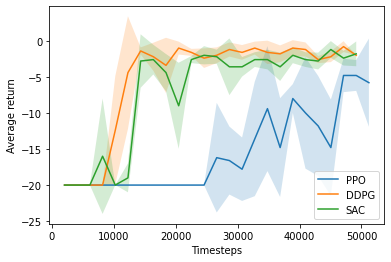

In [112]:
results = {'PPO': './logs/minigolf/ppo',
           'DDPG': './logs/minigolf/ddpg',
           'SAC': './logs/minigolf/sac'}
        
plot_results(results)